(2, 64, 64)


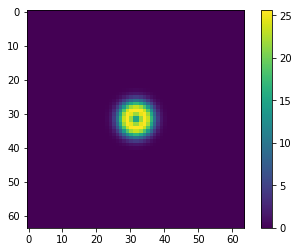

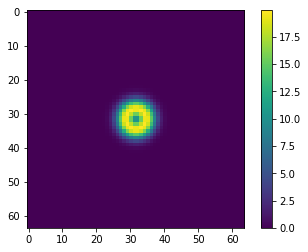

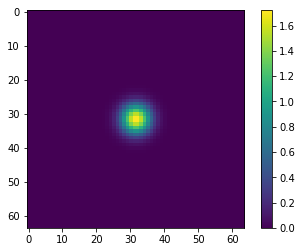

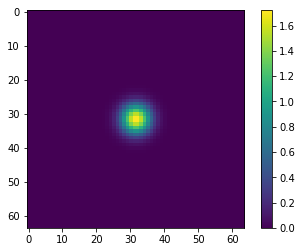

In [74]:
%matplotlib inline
import logging, logging.config
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger(__name__)

import os
import sys
from pathlib import Path
import pickle
import importlib


rootdir = Path().resolve()
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../source')))
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../config')))

from setting_freq import *


import data_make 
import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
import solver_mfreq as s_freq
import plot_make 
importlib.reload(s_freq)
importlib.reload(data_make)

lambda_arr = np.array([0.8, 1.0])
lambda0 = 1.0
nu_arr = 1/lambda_arr
nu0 = 1/lambda0

#Making images
beta_func = lambda xx, yy: (0.01)* data_make.gaussian_function_2d(xx, yy, 0.03, 0.03, 0,0)
input_model, xx, yy = data_make.ring_make_multi_frequency(XNUM, YNUM, DX, DY, \
    RAD_RING, WIDTH_RING, nu_arr, nu0, beta_func, function = data_make.gaussian_function_1d)
print(np.shape(input_model))


outfile = "input_model"
np.savez(outfile, model = input_model, others = beta_func(xx, yy) )

#"""
## Vertual Obervatory
obs_name = "test_observatory_mfreq"
obs_file = obs_name + ".pk"

if not os.path.exists(obs_file) or REPLACE_OBS:
    obs_ex = data_make.observatory_mfreq(input_model, NDATA , PERIOD, SN , OBS_DUR  , N_ANTE ,BASELINE_UVMAX, [0., 0], lambda_arr,lambda0, save_folder = FIG_FOLDER)
    obs_ex.set_antn()

    with open(obs_file, "wb") as f:
        pickle.dump(obs_ex, f)

else:
    with open(obs_file, "rb") as f:
        obs_ex = pickle.load(f) 

    ## Making obs data
vis_obs, num_mat, fft_now = obs_ex.obs_make(DX, DY, SN)
vis_test = vis_obs


## Setting priors for model
N_tot = XNUM * YNUM
model_init = np.zeros(2 * N_tot)
model_init[0:N_tot] = 3* np.random.rand(N_tot) 
model_init[N_tot:2*N_tot] =3



## Calc grad
lambda_l1 = 1e2
lambda_ltsv = 1e2


grad_flag = False
plot_input = True


data = np.load("../tests/%s.npz" % outfile)
image_nu0 = data["model"][0]
image_nu1 = data["model"][1]

if plot_input:
    plt.imshow(image_nu0)
    plt.colorbar()
    plt.show()
    
    plt.imshow(image_nu1)
    plt.colorbar()
    plt.show()
    
    plt.imshow(np.log(image_nu0/image_nu1)/np.log(nu_arr[0]/nu_arr[1]))
    plt.colorbar()
    plt.show()
    
    plt.imshow(beta_func(xx, yy))
    plt.colorbar()
    plt.show()
    
    
if grad_flag:
    grad_num = s_freq.grad_mfreq_numerical(model_init, vis_obs, nu_arr, nu0, lambda_l1, lambda_ltsv)
    grad_ana = s_freq.multi_freq_grad(model_init, vis_obs, nu_arr, nu0, lambda_l1, lambda_ltsv)
    plt.scatter(grad_ana, grad_num- grad_ana)
    plt.show()
    

(64, 64)
(2, 64, 64)
(64, 64)
(2, 64, 64)


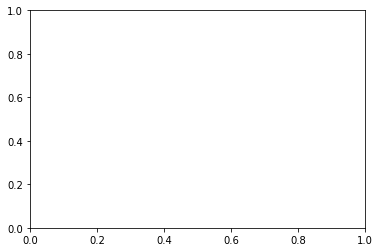

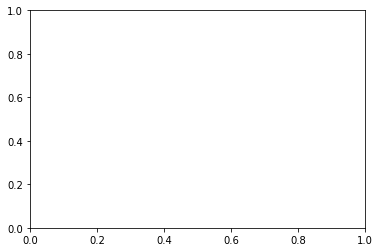

In [75]:
import solver_mfreq as s_freq
importlib.reload(s_freq)
importlib.reload(data_make)
mult_solve_init_flag = True

if mult_solve_init_flag:
    image_I0, beta,  model_freqs = s_freq.solver_mfreq_independent(s_freq.loss_function_arr_TSV, s_freq.grad_loss_tsv, s_freq.zero_func, \
                                    vis_obs, nu_arr, nu0, lambda_l1,lambda_ltsv)

142


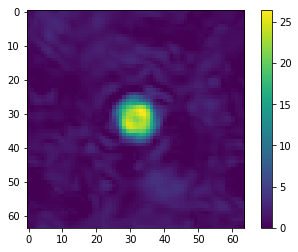

2827


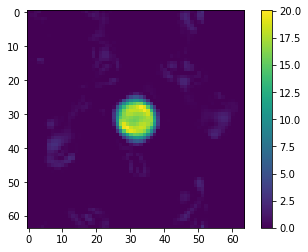

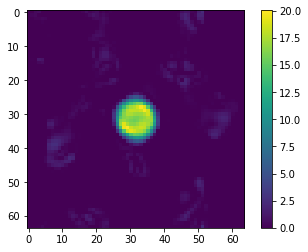

1.3015422278675703


/Users/masatakaaizawa/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


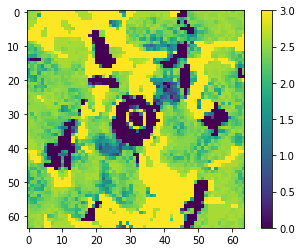

In [84]:
def count_n(arr, i):
    return len(arr[arr==i])

plt.imshow( model_freqs[0])
print(count_n(model_freqs[0], 0))
plt.colorbar()
plt.show()
plt.imshow( model_freqs[1])
print(count_n(model_freqs[1], 0))


plt.colorbar()
plt.show()
plt.imshow(image_I0)
plt.colorbar()
plt.show()
print(np.max(np.log10(image_I0)))
plt.imshow(beta)
plt.colorbar()
plt.show()


In [78]:

bounds = []
for i in range(N_tot):
    bounds.append([0,30])

for i in range(N_tot):
    bounds.append([0,3])
bounds = np.array(bounds)
f_cost= s_freq.multi_freq_cost_l1_tsv
df_cost = s_freq.multi_freq_grad
models_init = np.append(image_I0, beta)
result = s_freq.solver_mfreq(f_cost,df_cost, model_init, bounds,  vis_obs, nu_arr, nu0, lambda_l1, lambda_ltsv) 
image, beta = s_freq.x_to_I_beta(result[0])
np.savez('test', image=image, beta = beta)

In [79]:
print(result[0])

[0.         0.         0.         ... 2.59789828 2.49476623 2.41283669]


In [80]:
def separate_result(result):
    output = result[0]
    N_data = int( len(output)/2)
    output = np.array(list(output))
    image = output[0:N_data]
    beta = output[N_data:2*N_data]
    return image, beta

In [81]:
image, beta = s_freq.x_to_I_beta(result[0])

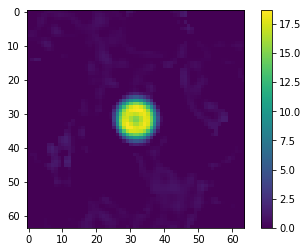

2576


/Users/masatakaaizawa/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


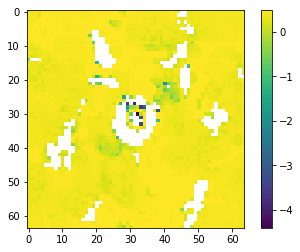

In [82]:
plt.imshow(image)
plt.colorbar()
plt.show()
print(len(image[image==0]))
plt.imshow(np.log10(beta))
plt.colorbar()
plt.show()